c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


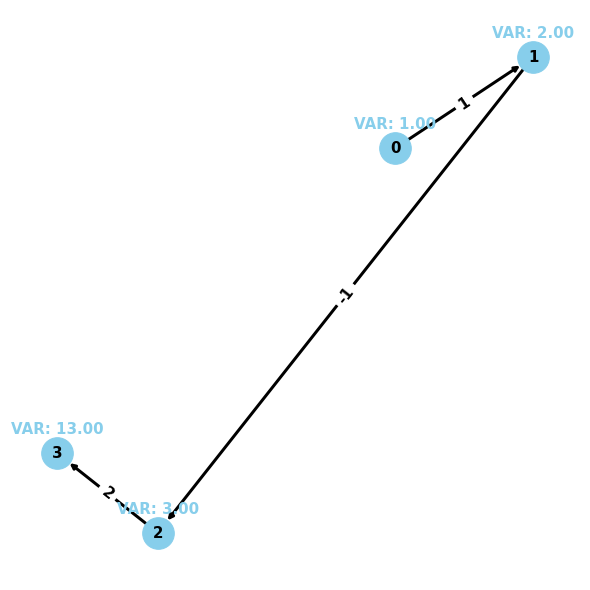

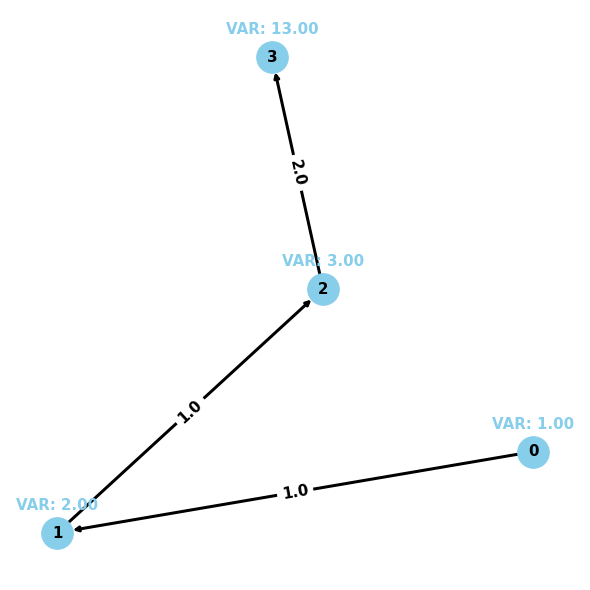

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from pyvis.network import Network

from DAG import DAG

dag = DAG(n = 4, roots = 1, strength=2, precalculate_paths = True, integer = True)
dag.mutate().plot()
dag.plot()

In [26]:
# dag.precalculate_paths = False

dag = DAG(n = 5, roots = 1, strength=2, precalculate_paths = False, integer = True)
from time import time
t = time()
sim = dag.get_simulated_var(100000)
print("time:", time() - t)
t = time()
ana = dag.get_analytical_var()
print("time:", time() - t)

for i in range(dag.size):
    print("simulated", i, ":",round(sim[i]), "| analytical", ":", round(ana[i]))

print("")
varsort = dag.get_varsortability(analytical = True, simulated = True, smart=True, N = 100000)
print("varsortability:", varsort)

time: 0.03297090530395508
time: 0.00702667236328125
simulated 0 : 1 | analytical : 1
simulated 1 : 5 | analytical : 5
simulated 2 : 30 | analytical : 30
simulated 3 : 31 | analytical : 31
simulated 4 : 16 | analytical : 16

varsortability: {'analytical': 0.8571428571428571, 'simulated': 0.8571428571428571, 'smart': 0.8571428571428572}


$V_a = \sum^{nodes}_i\sum_{j,k}\prod^{path_{j}}_j\prod^{path_{ia}}_k W_j W_kV_i + V_a$

In [27]:
# genetic algorithm

start_adj = np.array([[0,1,1,1,1,1],[0,0,1,1,1,1],[0,0,0,1,1,1],[0,0,0,0,1,1],[0,0,0,0,0,1], [0,0,0,0,0,0]]).astype(float)

population = 50


mkdag = lambda: DAG(n = start_adj.shape[0], roots = 1, strength = 15, precalculate_paths = False, adjacency_matrix = start_adj, integer = True)

start_dags = [mkdag() for _ in range(population)]


# thomas siger lav grupper 
true = True

N = 200
for i in range(N):
    print("")
    print("generation", i)
    start_dags = sorted(start_dags, key = lambda x: x.get_varsortability(analytical = True, simulated = False, N = 1000000)["analytical"], reverse = False)
    start_dags = start_dags[:(population // 2)]

    for j in range(population // 2):
        start_dags.append(start_dags[j].mutate(1 - i/N))

    if i < N//2:
        new = mkdag()
        start_dags.append(new.mutate())

    for j in range(1):
        print("varsortability:", start_dags[j].get_varsortability(analytical = True, simulated = True, smart = True,  N = 100000))
        print("continous_varsortability:", start_dags[j].get_continous_varsortability(analytical = True, simulated = False, N = 100000))


generation 0
varsortability: {'analytical': 1.0, 'simulated': 1.0, 'smart': 1.0}
continous_varsortability: {'analytical': 26.684449340278903}

generation 1
varsortability: {'analytical': 0.9298245614035088, 'simulated': 0.9298245614035088, 'smart': 0.8857142857142857}
continous_varsortability: {'analytical': 19.134810487415304}

generation 2
varsortability: {'analytical': 0.9122807017543859, 'simulated': 0.9473684210526315, 'smart': 0.9142857142857143}
continous_varsortability: {'analytical': 19.31592212377091}

generation 3
varsortability: {'analytical': 0.9122807017543859, 'simulated': 0.9473684210526315, 'smart': 0.9142857142857143}
continous_varsortability: {'analytical': 19.31592212377091}

generation 4
varsortability: {'analytical': 0.8421052631578947, 'simulated': 0.8421052631578947, 'smart': 0.7714285714285715}
continous_varsortability: {'analytical': 18.308106718083486}

generation 5
varsortability: {'analytical': 0.8421052631578947, 'simulated': 0.8421052631578947, 'smart': 

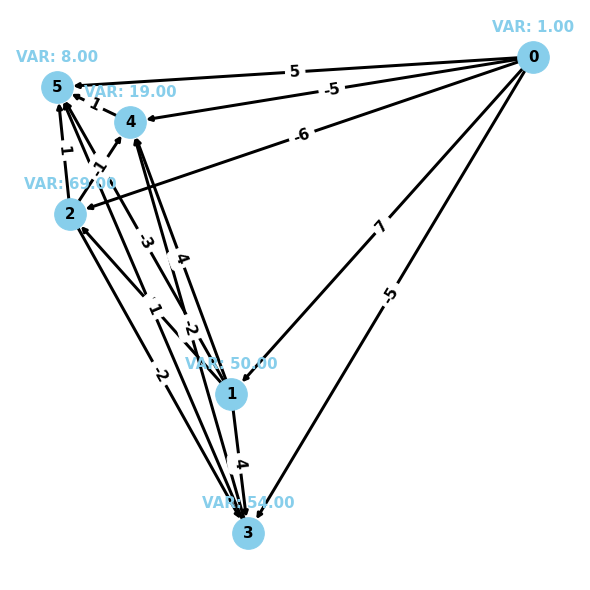

array([ 1., 50., 69., 54., 19.,  8.])

In [150]:
start_dags[0].plot()

start_dags[0].get_analytical_var()

In [153]:
start_dags[0].adjacency_matrix

array([[ 0,  7, -6, -5, -5,  5],
       [ 0,  0,  2,  4,  4, -3],
       [ 0,  0,  0, -2, -1,  1],
       [ 0,  0,  0,  0, -2,  1],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0]])

In [129]:
start_dags[2].get_simulated_var(10000).astype(int)

array([   1,   37,  105,  203, 1201,  416])

In [31]:
from time import time
t = time()


for _ in range(100):
    d = DAG(n = 6, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = start_adj).get_varsortability(analytical = False, simulated = True, N = 100000)["simulated"]

print("time:", time() - t)

t = time()

for _ in range(100):
    d = DAG(n = 6, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = start_adj).get_varsortability(analytical = True, simulated = False)["analytical"]

print("time:", time() - t)

time: 3.2647793292999268
time: 2.5968685150146484


In [36]:
# Gradient descent
from scipy.optimize import minimize
from tqdm.notebook import tqdm  

start_adj = np.array([[0,1,0,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,0,1],[0,0,0,0,0]]).astype(float)

def f(x):
    ad = np.zeros_like(start_adj)
    ad[start_adj == 1] = x
    d = DAG(n = 5, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = ad)
    return d.get_continous_varsortability(analytical = False, simulated = True, N = 1000000)["simulated"]


_min = 1000
x0 = np.ones(np.sum(start_adj == 1))
# x0 = start_dags[0].adjacency_matrix[start_dags[0].adjacency_matrix != 0].astype(float).copy()
best = np.array([x0, x0, x0])
for i in tqdm(range(5)):
    res = minimize(f, x0, bounds = [(-2,2) for i in range(len(x0))], options={'disp': True, 'eps': 0.1, 'ftol': 1e-13, 'gtol': 1e-13, 'maxiter' : 10000, 'maxfun' : 1000})
    if (res.fun < _min):
        _min = res.fun
        print(res.fun)
        best[1:] = best[:-1]
        best[0] = res.x

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

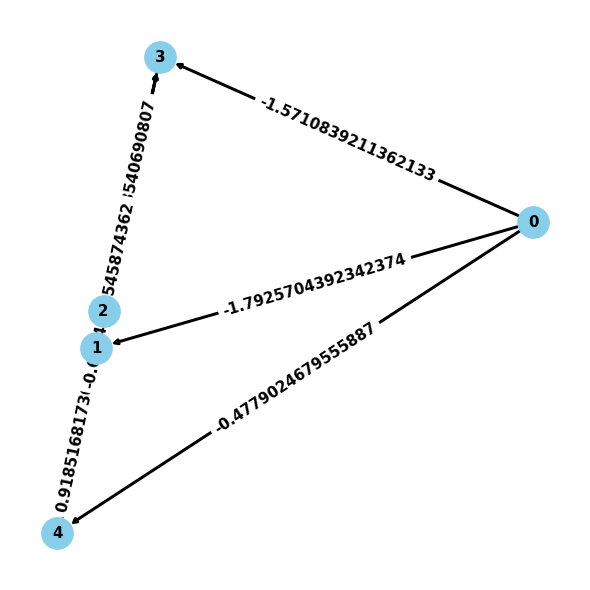

[[ 0.         -1.79257044  0.         -1.57108392 -0.47790247]
 [ 0.          0.         -1.61055881  0.63262079  1.4691218 ]
 [ 0.          0.          0.          0.68154354  0.91851682]
 [ 0.          0.          0.          0.         -0.62841065]
 [ 0.          0.          0.          0.          0.        ]]
{'analytical': 0.5454545454545454, 'simulated': 0.5454545454545454}
{'analytical': 3.4433323627139196, 'simulated': 3.444709527491217}


In [110]:
ad = np.zeros_like(start_adj)
ad[start_adj == 1] = np.array(best[0])

dag = DAG(n = 5, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = ad)
dag.plot()
print(ad)

print(dag.get_varsortability(analytical=True, simulated=True, N = 100000))

print(dag.get_continous_varsortability(analytical = True, simulated = True, N = 1000000))